In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from seaborn import heatmap

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering,SpectralClustering

In [4]:
def get_B_and_weight_vec(matrix,threshold):
    N = matrix.shape[0]
    A = matrix

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshold:   
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return B, weight_vec

In [5]:
def algorithm(B, weight_vec,seeds, K=15000,alpha=0.01, lambda_nLasso=None, check_s=False):
    E, N = B.shape
#     weight_vec = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5
    
    
    seednodesindicator= np.zeros(N)
    seednodesindicator[seeds] = 1   
    
    noseednodeindicator = np.ones(N)
    noseednodeindicator[seeds] = 0
    
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(weight_vec))
    
    if check_s:
        s = 0.0
        for item in range(len(weight_vec)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += weight_vec[item]
            elif i >= N1 > j:
                s += weight_vec[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * weight_vec), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[seeds] = (newx[seeds] + Gamma_vec[seeds]) / (1 + Gamma_vec[seeds])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)

    return history
   

# 11 nodes with Various boundary weight

In [6]:
# generate weights matrix
def generate_A(N=10, A_0=0.9):
    weights_matrix = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            if i == 9:
                weights_matrix[i][10] = A_0
                weights_matrix[10][i] = A_0
                continue
            if j == i+1:
                weights_matrix[i][j] = 1
                weights_matrix[j][i] = 1
    return weights_matrix

In [7]:
def run_chain(matrix,seeds,K=100, alpha=0.02,threshold = 0.000001, lambda_nLasso=0.1):
    B, weight_vec = get_B_and_weight_vec(matrix,threshold = threshold)
    X = []
    for s in seeds:
        history = algorithm(B, weight_vec,seeds=s, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
        X.append(np.nan_to_num(history[-1]))
    X = np.array(X)
#     start = datetime.datetime.now()
    spectral_labels = spectral_clustering(matrix, n_clusters=2)
#     print ('spectral clustering time: ', datetime.datetime.now() - start)
    return X, spectral_labels

In [8]:
N = 11
for A_0 in [0.2,0.5,0.7,0.9,0.99]:
    print('A_0 =',A_0)
    weights_matrix_10 = generate_A(N=N, A_0=A_0)
    seeds = np.random.choice(np.arange(1,N),5,replace=False)
#     print("seeds:",seeds)
    ALPHA = 0.01
    LAMBDA = 0.05
    X, spectral_labels = run_chain(weights_matrix_10,seeds=seeds,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X.T)

    true_labels =np.array([0 for i in range(9)]+[1 for i in range(N-9)])
    if kmeans.labels_[0] == 0:
        print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
    else:
        print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

    if spectral_labels[0] == 0:
        print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
    else:
        print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    print('\n')

A_0 = 0.2
our method accuracy:  0.9090909090909091
spectral clustering accuracy:  0.6363636363636364


A_0 = 0.5
our method accuracy:  0.9090909090909091
spectral clustering accuracy:  0.6363636363636364


A_0 = 0.7
our method accuracy:  1.0
spectral clustering accuracy:  0.6363636363636364


A_0 = 0.9
our method accuracy:  0.45454545454545453
spectral clustering accuracy:  0.6363636363636364


A_0 = 0.99
our method accuracy:  1.0
spectral clustering accuracy:  0.6363636363636364




A_0 = 0.2


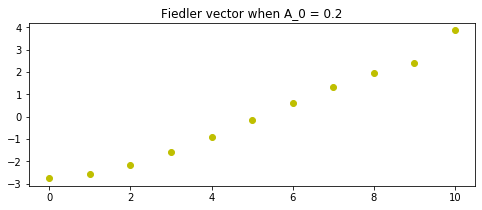

A_0 = 0.5


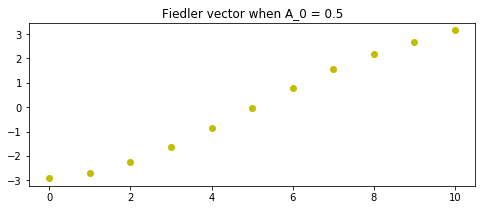

A_0 = 0.7


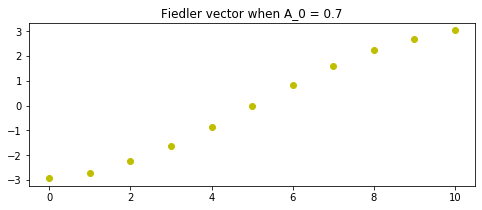

A_0 = 0.9


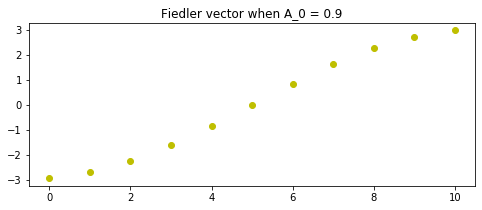

A_0 = 0.99


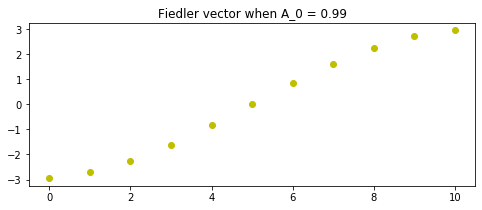

In [83]:
from scipy.sparse.csgraph import laplacian
import scipy.linalg as la
N = 11
for A_0 in [0.2,0.5,0.7,0.9,0.99]:
    print('A_0 =',A_0)
    weights_matrix_10 = generate_A(N=N, A_0=A_0)
    l=laplacian(weights_matrix_10)

    eig_values, eig_vectors = la.eig(l)
    fiedler_pos = np.where(eig_values.real == np.sort(eig_values.real)[1])[0][0]
    fiedler_vector = np.transpose(eig_vectors)[fiedler_pos]
    plt.figure(figsize=(8,3))
    plt.title(f"Fiedler vector when A_0 = {A_0}")
    plt.plot(fiedler_vector.real[0:N]*(-7),'yo')
    plt.show()
    plt.close()

# 40 nodes 

A_0 = 0.7
seed: 0
true labels:  [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
our method accuracy:  0.975
spectral clustering accuracy:  0.725




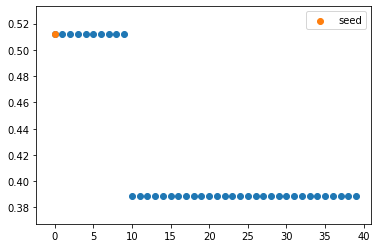

A_0 = 0.7
seed: 6
true labels:  [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
our method accuracy:  0.975
spectral clustering accuracy:  0.725




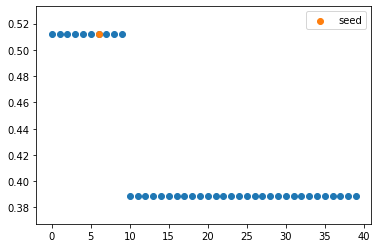

A_0 = 0.7
seed: 3
true labels:  [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
our method accuracy:  0.975
spectral clustering accuracy:  0.725




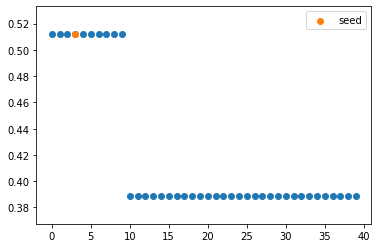

A_0 = 0.7
seed: 15
true labels:  [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
our method accuracy:  0.6
spectral clustering accuracy:  0.725




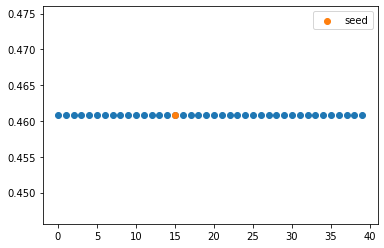

A_0 = 0.7
seed: 25
true labels:  [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]
our method accuracy:  0.725
spectral clustering accuracy:  0.725




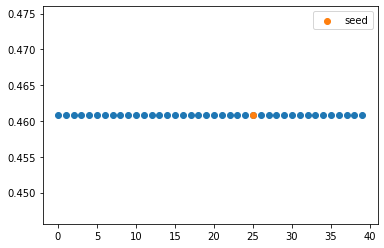

In [30]:
## Use a single node as seed, run algorithm for one time
N = 40
A_0=0.7
for seed in [0,6,3,15,25]:
    print('A_0 =',A_0)
    weights_matrix_40 = generate_A(N=N, A_0=A_0)
    print("seed:",seed)
    ALPHA = 0.03
    LAMBDA = 0.5
    B, weight_vec = get_B_and_weight_vec(weights_matrix_40,threshold = 0.001)
    history = algorithm(B, weight_vec,seeds=seed, K=2000, alpha=ALPHA, lambda_nLasso=LAMBDA)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(np.nan_to_num(history[-1]).reshape(-1,1))
    spectral_labels = spectral_clustering(weights_matrix_40, n_clusters=2)
    true_labels =np.array([0 for i in range(9)]+[1 for i in range(N-9)])
    print('true labels: ',true_labels)
    if kmeans.labels_[0] == 0:
        print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
    else:
        print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

    if spectral_labels[0] == 0:
        print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
    else:
        print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    print('\n')
    plt.scatter(np.arange(N),history[-1])
    plt.scatter(seed,history[-1][seed],label='seed')
    plt.legend()
    plt.show()
    plt.close()

In [32]:
N = 40
for A_0 in [0.2,0.5,0.7,0.9,0.99]:
    print('A_0 =',A_0)
    weights_matrix_100 = generate_A(N=N, A_0=A_0)
    seeds = np.random.choice(np.arange(0,N),10,replace=False)
    print("seeds:",seeds)
    ALPHA = 0.03
    LAMBDA = 0.5
    X, spectral_labels = run_chain(weights_matrix_100,seeds=seeds,K=2000,alpha=ALPHA,lambda_nLasso=LAMBDA)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X.T)

    true_labels =np.array([0 for i in range(9)]+[1 for i in range(N-9)])
    print(len(true_labels))
    print(kmeans.labels_ == true_labels)
    print(np.where(kmeans.labels_ == true_labels)[0])
    if kmeans.labels_[0] == 0:
        print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
    else:
        print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

    if spectral_labels[0] == 0:
        print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
    else:
        print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    print('\n')

A_0 = 0.2
seeds: [12  8 17 23  5 26  4  1 32  0]
40
[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[9]
our method accuracy:  0.975
spectral clustering accuracy:  0.775


A_0 = 0.5
seeds: [ 9 16 12 20 24 26 11  8 37 39]
40
[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[9]
our method accuracy:  0.975
spectral clustering accuracy:  0.725


A_0 = 0.7
seeds: [ 6 10 13 28 14 11  3 26  4 35]
40
[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False

A_0 = 0.2


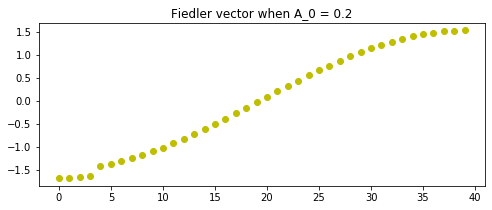

A_0 = 0.5


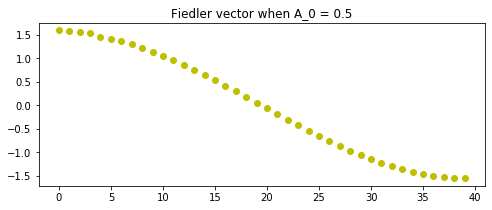

A_0 = 0.7


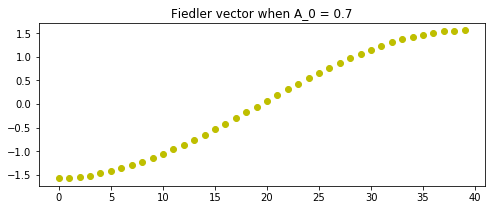

A_0 = 0.9


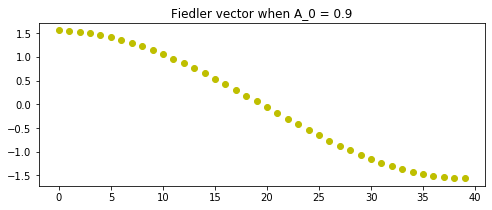

A_0 = 0.99


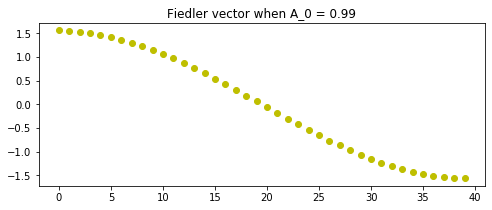

In [26]:
from scipy.sparse.csgraph import laplacian
import scipy.linalg as la
N = 40
for A_0 in [0.2,0.5,0.7,0.9,0.99]:
    print('A_0 =',A_0)
    weights_matrix_100 = generate_A(N=N, A_0=A_0)
    l=laplacian(weights_matrix_100)

    eig_values, eig_vectors = la.eig(l)
    fiedler_pos = np.where(eig_values.real == np.sort(eig_values.real)[1])[0][0]
    fiedler_vector = np.transpose(eig_vectors)[fiedler_pos]
    plt.figure(figsize=(8,3))
    plt.title(f"Fiedler vector when A_0 = {A_0}")
    plt.plot(fiedler_vector.real[0:N]*(-7),'yo')
    plt.show()
    plt.close()

# Gaussian Ball + Rectangle

In [23]:
def get_A_B_and_edge_weights_points(points,threshold=0.2):
    N = len(points)
    clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0).fit(points)
    A = clustering.affinity_matrix_
#     print(np.max(A.flatten()))
    row = []
    col = []
    data = []
    edge_weights = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshold:
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            edge_weights.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    edge_weights = np.array(edge_weights)
    return A, B, edge_weights

def generate_seeds(A,B,N,proportion):
#use unweighted A and its square to explore a local neighborhood of the initial seed
    def filter_seeds(initial_seed):
        i=50
        while True:
            #b is a set of nodes with more than i common neighbors with the initial seed
            b = set(np.where(S[initial_seed]>i)[0]) 
            samplingset=list(a.intersection(b))
            if len(samplingset)<5:   
                break
            elif len(samplingset)>N*proportion:   
                i+=1
            else :
                break
        print(i)
        samplingset.append(initial_seed)
        return samplingset
    
    #squared A
    unweighted_A = (A>0).astype(int)-np.eye(A.shape[0],A.shape[1]) 
    S = np.dot(unweighted_A,unweighted_A)
    degrees = np.asarray(np.sum(abs(B),0))[0]
    
    #randomly select some nodes as initial seeds, the degree of these nodes must be higher than a certain value
    initial_seeds = np.random.choice(np.where(degrees>12)[0],6,replace=False)
    print('initial_seeds',initial_seeds)
    samplingsets = []
    for s in initial_seeds:
        a = set(np.where(unweighted_A[s]>0)[0])  #include all the neighbors as candidate seeds
        samplingsets.append(filter_seeds(s))
    
    return samplingsets

initial_seeds [ 508  618  682 1209  591  113]
50
50
50
312
50
50


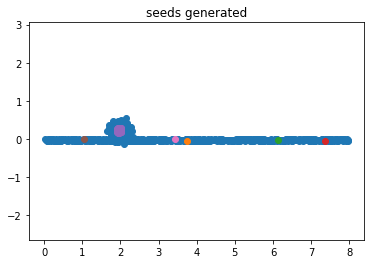

In [24]:
def make_GU(n1,n2):
    u = np.random.uniform(low=[0,-0.05], high=[8.0,0], size=(n1,2))
    mean=[2,0.2]
    cov=[[0.01,0],[0,0.01]]
    g = np.random.multivariate_normal(mean, cov, n2)
    data = np.concatenate((u,g))
    return data,np.array([0]*n1+[1]*n2)

N1=700
N2=700
points = make_GU(n1=N1,n2=N2)

A,B,edge_weights=get_A_B_and_edge_weights_points(points[0],threshold=0.98) # Must use a large threshold

samplingsets = generate_seeds(A,B,N1+N2,0.1)

#visulize seeds generated
plt.scatter(points[0][:, 0], points[0][:, 1], label='0')
for samplingset in samplingsets:
    plt.scatter(points[0][samplingset, 0], points[0][samplingset,1],label='0')
plt.title('seeds generated')
plt.axis('equal')
plt.show()
plt.close()

The accuracy is:  0.9671428571428572


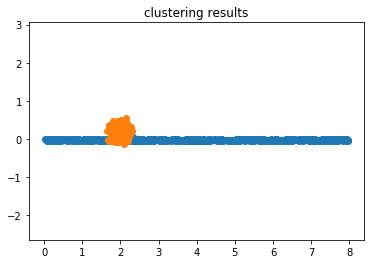

In [25]:
# run our algorithm for each batch of seeds, and stack the obtained graph signals into a feature matrix
# # feed the feature matrix into Kmeans to get the final cluster identities for each node.
ALPHA = 0.005
LAMBDA = 0.01
history = []
for samplingset in samplingsets:   
    hist = algorithm(B,edge_weights,samplingset,K=1000,alpha=ALPHA,lambda_nLasso=LAMBDA)
    history.append(np.nan_to_num(hist[-1]))
kmeans = KMeans(n_clusters=2).fit(np.array(history).T) 

data  = {'x':points[0][:,0],'y':points[0][:,1],'c':kmeans.labels_}
pd.DataFrame(data).to_csv('ourResult.csv',index=None)
true_labels = points[1]
if kmeans.labels_[0] == 0:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('The accuracy is: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

plt.scatter(points[0][np.where(kmeans.labels_ == 1), 0], points[0][np.where(kmeans.labels_ == 1), 1], label='0')
plt.scatter(points[0][np.where(kmeans.labels_ == 0), 0], points[0][np.where(kmeans.labels_ == 0), 1], label='0')
# plt.scatter(points[0][samplingset, 0], points[0][samplingset,1], c='r',label='0')
plt.title('clustering results')
plt.axis('equal')
plt.show()
plt.close() 


The accuracy is:  0.7792857142857142


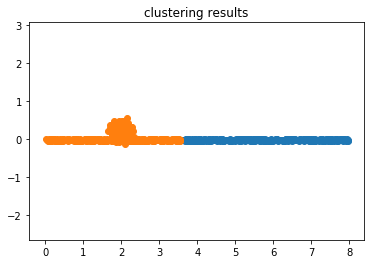

In [26]:
spectral_labels = spectral_clustering(A,n_clusters=2)
data  = {'x':points[0][:,0],'y':points[0][:,1],'c':spectral_labels}
pd.DataFrame(data).to_csv('spectralResult.csv',index=None)
if spectral_labels[0] == 0:
    print('The accuracy is: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
else:
    print('The accuracy is: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))

plt.scatter(points[0][np.where(spectral_labels == 1), 0], points[0][np.where(spectral_labels == 1), 1], label='0')
plt.scatter(points[0][np.where(spectral_labels == 0), 0], points[0][np.where(spectral_labels == 0), 1], label='0')
# plt.scatter(points[0][samplingset, 0], points[0][samplingset,1], c='r',label='0')
plt.title('clustering results')
plt.axis('equal')
plt.show()
plt.close()  